In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import time
from unidecode import unidecode
import py_stringmatching as string_match
from recordlinkage.preprocessing import phonetic

import recordlinkage
from recordlinkage.index import Block, SortedNeighbourhood
from recordlinkage.base import BaseCompareFeature

# All things model related
import scikitplot as skplt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, \
                            confusion_matrix, \
                            recall_score, \
                            precision_score, \
                            f1_score, \
                            ConfusionMatrixDisplay, \
                            average_precision_score, \
                            precision_recall_curve, \
                            auc

import networkx as nx # Used for turning a list of pairs into clusters

pd.set_option('display.max_columns', None)

# Read in the Data

The record linkage package actually provides several datasets that we can use for experimenting with ER : https://recordlinkage.readthedocs.io/en/latest/ref-datasets.html

In [2]:
from recordlinkage.datasets import load_febrl2

In [3]:
df = load_febrl2()
df.head(5)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,19080712,9497788
rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,19940319,6814956
rec-3004-org,aleisha,hobson,54,oliver street,inglewood,toowoomba,3175,qld,19290427,5967384
rec-1384-org,ethan,gazzola,49,sheaffe street,bimby vale,port pirie,3088,sa,19631225,3832742


# Data Normalization

**Purpose** : to reduce the noise in the model input data by creating consistency within the data fields. 

In [4]:
df.apply(
    lambda x : unidecode(x).lower().strip()
    if isinstance(x, str) # only non-str values will be NULL values
    else x
)

# Overall, if anything we did resulted in an empty cell, make it NULL
df.replace('', np.nan, inplace=True)

# Prep for the features we will be creating

### Break birth date into separate columns 

In [5]:
df['birth_year'] = df['date_of_birth'].apply(
    lambda date : date[0:4]
    if isinstance(date, str)
    else np.nan
)
df['birth_month'] = df['date_of_birth'].apply(
    lambda date : date[4:6]
    if isinstance(date, str)
    else np.nan
)
df['birth_day'] = df['date_of_birth'].apply(
    lambda date : date[6:]
    if isinstance(date, str)
    else np.nan
)
df.drop('date_of_birth', axis=1, inplace=True)
df.head(5)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,soc_sec_id,birth_year,birth_month,birth_day
rec_id,,,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,7535316,1930,02,13
rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,9497788,1908,07,12
rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,6814956,1994,03,19
rec-3004-org,aleisha,hobson,54,oliver street,inglewood,toowoomba,3175,qld,5967384,1929,04,27
rec-1384-org,ethan,gazzola,49,sheaffe street,bimby vale,port pirie,3088,sa,3832742,1963,12,25


### Tokenize the address columns

This is a fancy way of turning a string into a list of words. This format prepares us to use Soft TF-IDF as a method for comparing addresses to each other.

In [6]:
tokenizer = string_match.AlphabeticTokenizer()
df['address_1_tokens'] = df['address_1'].apply(
    lambda address: tokenizer.tokenize(address)
    if not pd.isnull(address)
    else []
)
df['address_2_tokens'] = df['address_2'].apply(
    lambda address: tokenizer.tokenize(address)
    if not pd.isnull(address)
    else []
)
df.drop(['address_1', 'address_2'], inplace = True, axis=1)
df.head(5)

,given_name,surname,street_number,suburb,postcode,state,soc_sec_id,birth_year,birth_month,birth_day,address_1_tokens,address_2_tokens
rec_id,,,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,kellerberrin,4510,vic,7535316,1930,02,13,"[forbes, street]",[wintersloe]
rec-712-dup-0,jacob,lanyon,5,beaconsfield upper,2602,vic,9497788,1908,07,12,"[milne, cove]",[wellwod]
rec-1321-org,brinley,efthimiou,35,scarborough,5211,qld,6814956,1994,03,19,"[sturdee, crescent]",[tremearne]
rec-3004-org,aleisha,hobson,54,toowoomba,3175,qld,5967384,1929,04,27,"[oliver, street]",[inglewood]
rec-1384-org,ethan,gazzola,49,port pirie,3088,sa,3832742,1963,12,25,"[sheaffe, street]","[bimby, vale]"


<img src="coffee name spelled wrong.jfif" width="500" height="500" />

#### Phonetic encoding the names

Deals with the issue of different variations of spelling the same name.

In [7]:
df['given_name_encodings'] = phonetic(df['given_name'], method='metaphone')
df['surname_encodings'] = phonetic(df['surname'], method='metaphone')
df[['given_name', 'given_name_encodings', 'surname', 'surname_encodings']]

C:\Users\emily.lynn\Anaconda3\envs\entity_resolution_talk\lib\site-packages\recordlinkage\preprocessing\encoding.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r"[\-\_\s]", "")
C:\Users\emily.lynn\Anaconda3\envs\entity_resolution_talk\lib\site-packages\recordlinkage\preprocessing\encoding.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r"[\-\_\s]", "")


,given_name,given_name_encodings,surname,surname_encodings
rec_id,,,,
rec-2778-org,sarah,SR,bruhn,BRN
rec-712-dup-0,jacob,JKB,lanyon,LNYN
rec-1321-org,brinley,BRNL,efthimiou,EF0M
rec-3004-org,aleisha,ALX,hobson,HBSN
rec-1384-org,ethan,E0N,gazzola,KSL
...,...,...,...,...
rec-1487-org,thomas,0MS,green,KRN
rec-1856-org,james,JMS,mcneill,MKNL
rec-3307-org,paige,PJ,lock,LK


# Blocking

The purpose of blocking is to reduce the number of overall record comparisons to a manageable amount by grouping records according to certain matching keys instead of comparing every record to every other record. Only records within the same group will be compared to each other.

In [8]:
# COLLAPSE
# equation for calculating the number of comparisons if every pair was compared to every
# single other pair
import math
math.factorial(100000)/(2*math.factorial(100000-2))

4999950000.0

In [9]:
num_records = len(df)
print(f'Number of table records : {num_records}')
every_possible_pair = recordlinkage.index.Full().index(df)
print(f'Max possible pairs to check : {len(every_possible_pair)}')

Number of table records : 5000
Max possible pairs to check : 12497500


In [10]:
phonetic_given_name_block = Block(left_on='given_name_encodings')
phonetic_given_name_block_pairs = phonetic_given_name_block.index(df)
print(f"No. of pairs based on phonetic given name blocks: {len(phonetic_given_name_block_pairs)} pairs")

No. of pairs based on phonetic given name blocks: 70652 pairs


In [11]:
phonetic_given_name_block_pairs

MultiIndex([(  'rec-1050-org',   'rec-2778-org'),
            ('rec-2254-dup-2',   'rec-2778-org'),
            ('rec-2254-dup-2',   'rec-1050-org'),
            (  'rec-1385-org',   'rec-2778-org'),
            (  'rec-1385-org',   'rec-1050-org'),
            (  'rec-1385-org', 'rec-2254-dup-2'),
            ( 'rec-370-dup-0',   'rec-2778-org'),
            ( 'rec-370-dup-0',   'rec-1050-org'),
            ( 'rec-370-dup-0', 'rec-2254-dup-2'),
            ( 'rec-370-dup-0',   'rec-1385-org'),
            ...
            (  'rec-3351-org',   'rec-2124-org'),
            (  'rec-3000-org',   'rec-1887-org'),
            (  'rec-1998-org',    'rec-809-org'),
            (  'rec-1926-org', 'rec-1010-dup-1'),
            (  'rec-3182-org',  'rec-134-dup-2'),
            (   'rec-134-org',  'rec-134-dup-2'),
            (   'rec-134-org',   'rec-3182-org'),
            (  'rec-1896-org',   'rec-1587-org'),
            (   'rec-715-org',   'rec-3179-org'),
            (   'rec-903-org',   '

In [12]:
phonetic_surname_block = Block(left_on='surname_encodings')
phonetic_surname_block_pairs = phonetic_surname_block.index(df)
print(f"No. of pairs based on phonetic surname blocks: {len(phonetic_surname_block_pairs)} pairs")

No. of pairs based on phonetic surname blocks: 54741 pairs


In [13]:
suburb_block = SortedNeighbourhood(left_on='suburb', window=3)
suburb_block_pairs = suburb_block.index(df)
print(f"No. of pairs based on sorted neighbourhood suburb blocks: {len(suburb_block_pairs)} pairs")

No. of pairs based on sorted neighbourhood suburb blocks: 28507 pairs


In [14]:
all_pairs_from_blocks = phonetic_given_name_block_pairs.append(phonetic_surname_block_pairs).append(suburb_block_pairs)
all_pairs_from_blocks = all_pairs_from_blocks.drop_duplicates(keep='first') # Don't want pairs in the list more than once
print(f'Total number of pairware comparisons after blocking: {len(all_pairs_from_blocks)}')

Total number of pairware comparisons after blocking: 151119


# Set up Similarity Metrics

Model training is mathematical, therefore the model must take in numbers instead of text as input. For each pair of records, we have to create a single 'feature vector' that shows how similar the fields from the different records are. All comparison values range from 0 to 1, with 0 meaning they don't match at all and 1 meaning they match perfectly. This is what the model will see and use to determine how likely it is that a pair is a match or not.

In [15]:
# COLLAPSE
# TFIDF is not provided in the recordlinkage package, so we have to implement it ourselves
class SoftTFIDF(BaseCompareFeature):
    """
    Parameters
    ----------
    labels_left : list, str, int
        The labels to use for comparing record pairs in the left
        dataframe.
    labels_right : list, str, int
        The labels to use for comparing record pairs in the right
        dataframe (linking) or left dataframe (duplicate detection).
    args : tuple
        Additional arguments to pass to the `_compare_vectorized`
        method.
    kwargs : tuple
        Keyword additional arguments to pass to the `_compare_vectorized`
        method.
    label : list, str, int
        The identifying label(s) for the returned values.
    """
    def __init__(self,
                 left_on,
                 right_on,
                 scorer,
                 label=None):
        super(SoftTFIDF, self).__init__(left_on, right_on, label=label)
        
        self.scorer = scorer
    
    def _compute_vectorized(self, s1, s2):
        
        conc = pd.Series(list(zip(s1, s2)))
        
        def soft_tfidf_apply(x):
            
            try:
                return self.scorer.get_raw_score(x[0], x[1])
            except Exception as err:
                if pandas.isnull(x[0]) or pandas.isnull(x[1]):
                    return np.nan
                else:
                    raise err
            
        return conc.apply(soft_tfidf_apply)

In [16]:
# initialize the comparison class
comparer = recordlinkage.Compare()

comparer.exact('state', 'state', label='state', missing_value=np.nan)
comparer.exact('given_name_encodings', 'given_name_encodings', label='given_name_encodings', missing_value=np.nan)
comparer.exact('surname_encodings', 'surname_encodings', label='surname_encodings', missing_value=np.nan)

comparer.string('street_number', 'street_number', method='levenshtein', label='street_number', missing_value=np.nan)
comparer.string('postcode', 'postcode', method='levenshtein', label='postcode', missing_value=np.nan)
comparer.string('soc_sec_id', 'soc_sec_id', method='levenshtein', label='soc_sec_id', missing_value=np.nan)
comparer.string('birth_year', 'birth_year', method='levenshtein', label='birth_year', missing_value=np.nan)
comparer.string('birth_month', 'birth_month', method='levenshtein', label='birth_month', missing_value=np.nan)
comparer.string('birth_day', 'birth_day', method='levenshtein', label='birth_day', missing_value=np.nan)

comparer.string('suburb', 'suburb', method='jaro', label='suburb', missing_value=np.nan)

# custom implemented soft tf-idf comparison algorithm
# In the background soft tf-idf is using the Jaro similarity measure
soft_tfidf_1 = string_match.SoftTfIdf(corpus_list = df['address_1_tokens'].tolist(), threshold=0.9)
soft_tfidf_2 = string_match.SoftTfIdf(corpus_list = df['address_2_tokens'].tolist(), threshold=0.9)
comparer.add(SoftTFIDF('address_1_tokens', 'address_1_tokens', scorer=soft_tfidf_1, label='address_1_tfidf'))
comparer.add(SoftTFIDF('address_2_tokens', 'address_2_tokens', scorer=soft_tfidf_2, label='address_2_tfidf'))

In [17]:
# calculate these comparison values for all of the record pairs
start_time = time.time()
feature_vectors = comparer.compute(all_pairs_from_blocks, df)
end_time = time.time()
print(f'Execution time: {(end_time - start_time)/60} minutes')

Execution time: 0.18122889598210654 minutes


In [18]:
feature_vectors.head(5)

state  given_name_encodings  surname_encodings  \
rec_id_1       rec_id_2                                                       
rec-1050-org   rec-2778-org    0.0                   1.0                0.0   
rec-2254-dup-2 rec-2778-org    0.0                   1.0                0.0   
               rec-1050-org    1.0                   1.0                0.0   
rec-1385-org   rec-2778-org    0.0                   1.0                0.0   
               rec-1050-org    1.0                   1.0                0.0   

                             street_number  postcode  soc_sec_id  birth_year  \
rec_id_1       rec_id_2                                                        
rec-1050-org   rec-2778-org       0.000000      0.75    0.000000        0.75   
rec-2254-dup-2 rec-2778-org       0.000000      0.00    0.000000        0.50   
               rec-1050-org       0.000000      0.00    0.285714        0.50   
rec-1385-org   rec-2778-org       0.333333      0.00    0.142857        0.50   
               rec-1050-org       0.333333      0.25    0.285714        0.50   

                             birth_month  birth_day    suburb  \
rec_id_1       rec_id_2                                         
rec-1050-org   rec-2778-org          0.5        0.0  0.449495   
rec-2254-dup-2 rec-2778-org          0.5        0.0  0.388889   
               rec-1050-org          0.5        0.0  0.449495   
rec-1385-org   rec-2778-org          0.5        0.5  0.527778   
               rec-1050-org          0.5        0.0  0.438131   

                             address_1_tfidf  address_2_tfidf  
rec_id_1       rec_id_2                                        
rec-1050-org   rec-2778-org         0.000005              0.0  
rec-2254-dup-2 rec-2778-org         0.000000              0.0  
               rec-1050-org         0.000000              0.0  
rec-1385-org   rec-2778-org         0.000000              0.0  
               rec-1050-org         0.000000              0.0

### Add missing data indication columns

In [19]:
# Create columns that indicate if certain features are missing
missing_vals = [np.nan]
missing_indicators = feature_vectors.isin(missing_vals)
#missing_indicators = missing_indicators[['industry', 'ship_country', 'bill_country', 'hgi_id', 'bill_postal', 'bill_state', 'bill_city', 'website', 'geo_loc']]
col_labels = {
    'given_name_encodings':'given_name_missing',
    'surname_encodings': 'surname_missing',
    'street_number': 'street_number_missing',
    'address_1_tfidf': 'address_1_missing',
    'address_2_tfidf':'address_2_missing',
    'suburb':'suburb_missing',
    'postcode':'postcode_missing',
    'state':'state_missing',
    'birth_year':'birth_year_missing',
    'birth_month':'birth_month_missing',
    'birth_day':'birth_day_missing',
    'soc_sec_id':'soc_sec_id_missing'
}
missing_indicators.rename(columns=col_labels, inplace=True)
missing_indicators = missing_indicators*1 # convert True/False to 1/0

# Replace null values with 0
feature_vectors = pd.merge(feature_vectors, missing_indicators, left_index=True, right_index=True)
feature_vectors.fillna(0, inplace=True)
feature_vectors.head(5)

state  given_name_encodings  surname_encodings  \
rec_id_1       rec_id_2                                                       
rec-1050-org   rec-2778-org    0.0                   1.0                0.0   
rec-2254-dup-2 rec-2778-org    0.0                   1.0                0.0   
               rec-1050-org    1.0                   1.0                0.0   
rec-1385-org   rec-2778-org    0.0                   1.0                0.0   
               rec-1050-org    1.0                   1.0                0.0   

                             street_number  postcode  soc_sec_id  birth_year  \
rec_id_1       rec_id_2                                                        
rec-1050-org   rec-2778-org       0.000000      0.75    0.000000        0.75   
rec-2254-dup-2 rec-2778-org       0.000000      0.00    0.000000        0.50   
               rec-1050-org       0.000000      0.00    0.285714        0.50   
rec-1385-org   rec-2778-org       0.333333      0.00    0.142857        0.50   
               rec-1050-org       0.333333      0.25    0.285714        0.50   

                             birth_month  birth_day    suburb  \
rec_id_1       rec_id_2                                         
rec-1050-org   rec-2778-org          0.5        0.0  0.449495   
rec-2254-dup-2 rec-2778-org          0.5        0.0  0.388889   
               rec-1050-org          0.5        0.0  0.449495   
rec-1385-org   rec-2778-org          0.5        0.5  0.527778   
               rec-1050-org          0.5        0.0  0.438131   

                             address_1_tfidf  address_2_tfidf  state_missing  \
rec_id_1       rec_id_2                                                        
rec-1050-org   rec-2778-org         0.000005              0.0              0   
rec-2254-dup-2 rec-2778-org         0.000000              0.0              0   
               rec-1050-org         0.000000              0.0              0   
rec-1385-org   rec-2778-org         0.000000              0.0              0   
               rec-1050-org         0.000000              0.0              0   

                             given_name_missing  surname_missing  \
rec_id_1       rec_id_2                                            
rec-1050-org   rec-2778-org                   0                0   
rec-2254-dup-2 rec-2778-org                   0                0   
               rec-1050-org                   0                0   
rec-1385-org   rec-2778-org                   0                0   
               rec-1050-org                   0                0   

                             street_number_missing  postcode_missing  \
rec_id_1       rec_id_2                                                
rec-1050-org   rec-2778-org                      0                 0   
rec-2254-dup-2 rec-2778-org                      0                 0   
               rec-1050-org                      0                 0   
rec-1385-org   rec-2778-org                      0                 0   
               rec-1050-org                      0                 0   

                             soc_sec_id_missing  birth_year_missing  \
rec_id_1       rec_id_2                                               
rec-1050-org   rec-2778-org                   0                   0   
rec-2254-dup-2 rec-2778-org                   0                   0   
               rec-1050-org                   0                   0   
rec-1385-org   rec-2778-org                   0                   0   
               rec-1050-org                   0                   0   

                             birth_month_missing  birth_day_missing  \
rec_id_1       rec_id_2                                               
rec-1050-org   rec-2778-org                    0                  0   
rec-2254-dup-2 rec-2778-org                    0                  0   
               rec-1050-org                    0                  0   
rec-1385-org   rec-2778-org                    0              

# Basic Overall Similarity Score

In [20]:
scored_feature_vectors = feature_vectors.copy()
scored_feature_vectors['naive_score'] = scored_feature_vectors.loc[:, 'state':'address_2_tfidf'].sum(axis=1)/(len(feature_vectors.columns)/2)
scored_feature_vectors = scored_feature_vectors.sort_values(by=['naive_score'], ascending=False)
scored_feature_vectors

,,state,given_name_encodings,surname_encodings,street_number,postcode,soc_sec_id,birth_year,birth_month,birth_day,suburb,address_1_tfidf,address_2_tfidf,state_missing,given_name_missing,surname_missing,street_number_missing,postcode_missing,soc_sec_id_missing,birth_year_missing,birth_month_missing,birth_day_missing,suburb_missing,address_1_missing,address_2_missing,naive_score
rec_id_1,rec_id_2,,,,,,,,,,,,,,,,,,,,,,,,,
rec-3304-org,rec-3304-dup-0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
rec-3409-dup-1,rec-3409-org,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
rec-2544-org,rec-2544-dup-3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
rec-3550-org,rec-3550-dup-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
rec-2667-org,rec-2667-dup-1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rec-2521-org,rec-3537-org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511111,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,0.042593
rec-2744-org,rec-220-org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.455556,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,0.037963
rec-2744-dup-1,rec-220-org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.455556,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,0.037963


Technically you could stop here and not use any ML... 

<img src="https://media.giphy.com/media/StcQ5UIWPW72sIJMPW/giphy.gif" width="500" height="500" />

In [21]:
df, links = load_febrl2(return_links=True)

In [22]:
i = 0
for index, row in scored_feature_vectors.iterrows():
    flipped_index = (index[1], index[0])
    if (index in links) or (flipped_index in links):
        print(f"{round(scored_feature_vectors.loc[index]['naive_score'], 3):.2f} : MATCH")
    else:
        print(f"{round(scored_feature_vectors.loc[index]['naive_score'], 3):.2f} : NOT A MATCH")
    i += 1
    if i > 5000: # Not printing every single one
        break

1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
1.00 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH
0.99 : MATCH

So its those ones in the middle that are what ML can really help us to catch, when its not just a clear line between matches and non-matches

# Labeling

Record Linkage also provides a great labeling tool to make creating ground truth MUCH easier: https://j535d165.github.io/recordlinkage-annotator/

--- COLLAPSE ---

But that basic similarity score isn't totally useless - it can help us get more positive examples to use when training our model.

In [23]:
print(f'{(len(links)/len(every_possible_pair))*100:.2f}% of all possible pairs are true matches')

0.02% of all possible pairs are true matches


In [24]:
print(f'{(len(links)/len(all_pairs_from_blocks))*100:.2f}% of all pairs created from blocks are true matches')

1.28% of all pairs created from blocks are true matches


If we just pull from the list of pairs randomly, the chances that we are going to get a positive examples for the model to see are low.

In [25]:
obvious_matches = scored_feature_vectors[scored_feature_vectors['naive_score']==1.0]
len(obvious_matches)

18

In [26]:
obvious_nonmatches = scored_feature_vectors[scored_feature_vectors['naive_score']<=0.1]
len(obvious_nonmatches)

735

In [27]:
highly_likely_pairs = scored_feature_vectors[(scored_feature_vectors['naive_score']>=0.75) 
                                             & (scored_feature_vectors['naive_score']<1.0)]
print(f'No. of highly likely pairs : {len(highly_likely_pairs)}')

No. of highly likely pairs : 1438


In [28]:
likely_pairs = scored_feature_vectors[(scored_feature_vectors['naive_score']>=0.6) 
                                      & (scored_feature_vectors['naive_score']<0.75)]
print(f'No. of likely pairs : {len(likely_pairs)}')

No. of likely pairs : 347


In [29]:
possible_pairs = scored_feature_vectors[(scored_feature_vectors['naive_score']>=0.5) 
                                        & (scored_feature_vectors['naive_score']<0.6)]
print(f'No. of possible pairs : {len(possible_pairs)}')

No. of possible pairs : 99


In [30]:
unlikely_pairs = scored_feature_vectors[(scored_feature_vectors['naive_score']<0.5) 
                                        & (scored_feature_vectors['naive_score']>0.1)]
print(f'No. of unlikely pairs : {len(unlikely_pairs)}')

No. of unlikely pairs : 148482


Now we can pull examples from each section to give the model examples of differing amount of similarity/disimilarity. 

In [31]:
# COLLAPSE
num_to_sample = 50
random_state = 234
highly_likely_pairs_to_label = highly_likely_pairs.sample(n=num_to_sample, random_state=random_state)
likely_pairs_to_label = likely_pairs.sample(n=num_to_sample, random_state=random_state)
possible_pairs_to_label = possible_pairs.sample(n=num_to_sample, random_state=random_state)
unlikely_pairs_to_label = unlikely_pairs.sample(n=num_to_sample, random_state=random_state)

all_pairs_to_label = pd.concat([highly_likely_pairs_to_label, likely_pairs_to_label, possible_pairs_to_label, unlikely_pairs_to_label], axis=0)
shuffled_pairs_to_label = all_pairs_to_label.sample(frac=1, random_state=random_state) # shuffles the data
shuffled_pairs_to_label_index = shuffled_pairs_to_label.index

### Prepare data for the labelers

The labelers need to see the test data instead of the comparison metric data in order to make their decisions.
I also like to have labeling done off of the non-normalized data so that our normalization does not effect the choices. 

In [32]:
original_df = load_febrl2()

Here we add column names to the fields, since the annotator doesn't automatically display column names.

In [33]:
# Make everything strings
original_df.fillna('None Given', inplace=True)
original_df = original_df.astype(str)

for column in original_df.columns:
    original_df[column] = original_df[column].apply(
        lambda x : column.upper() + ' : ' + x 
    )
original_df.head(5)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,GIVEN_NAME : sarah,SURNAME : bruhn,STREET_NUMBER : 44,ADDRESS_1 : forbes street,ADDRESS_2 : wintersloe,SUBURB : kellerberrin,POSTCODE : 4510,STATE : vic,DATE_OF_BIRTH : 19300213,SOC_SEC_ID : 7535316
rec-712-dup-0,GIVEN_NAME : jacob,SURNAME : lanyon,STREET_NUMBER : 5,ADDRESS_1 : milne cove,ADDRESS_2 : wellwod,SUBURB : beaconsfield upper,POSTCODE : 2602,STATE : vic,DATE_OF_BIRTH : 19080712,SOC_SEC_ID : 9497788
rec-1321-org,GIVEN_NAME : brinley,SURNAME : efthimiou,STREET_NUMBER : 35,ADDRESS_1 : sturdee crescent,ADDRESS_2 : tremearne,SUBURB : scarborough,POSTCODE : 5211,STATE : qld,DATE_OF_BIRTH : 19940319,SOC_SEC_ID : 6814956
rec-3004-org,GIVEN_NAME : aleisha,SURNAME : hobson,STREET_NUMBER : 54,ADDRESS_1 : oliver street,ADDRESS_2 : inglewood,SUBURB : toowoomba,POSTCODE : 3175,STATE : qld,DATE_OF_BIRTH : 19290427,SOC_SEC_ID : 5967384
rec-1384-org,GIVEN_NAME : ethan,SURNAME : gazzola,STREET_NUMBER : 49,ADDRESS_1 : sheaffe street,ADDRESS_2 : bimby vale,SUBURB : port pirie,POSTCODE : 3088,STATE : sa,DATE_OF_BIRTH : 19631225,SOC_SEC_ID : 3832742


In [34]:
recordlinkage.write_annotation_file(
    'annotation_file.json',
    shuffled_pairs_to_label_index[:10],
    original_df
)

--- END OF COLLAPSE ---

For this example we're not going to take the time to go label all this data...we'll just take advantage of the ground truth that is provided for this dataset by the package:

# Train the Model

### Generate some Ground Truth 

In [35]:
obvious_matches_gt = pd.concat(
    [obvious_matches, pd.DataFrame({'label':1}, index=obvious_matches.index)],
    axis=1
)[:2]
obvious_nonmatches_gt = pd.concat(
    [obvious_nonmatches, pd.DataFrame({'label':0}, index=obvious_nonmatches.index)],
    axis=1
)
# [:188]

# These are the pairs that I pulled from the different slices we created using the basic similarity score
sampled_pairs_gt = pd.concat(
    [shuffled_pairs_to_label, pd.DataFrame({'label':0}, index=shuffled_pairs_to_label.index)],
    axis=1
)
# Using the answers provided by the package to simulate the labeling process
for index in sampled_pairs_gt.index:
    flipped_index = (index[1], index[0])
    if (index in links) or (flipped_index in links):
        sampled_pairs_gt.at[index,'label'] = 1
        
ground_truth = pd.concat(
    [
    obvious_matches_gt,
    obvious_nonmatches_gt,
    sampled_pairs_gt,
    ],
    verify_integrity=True
)
ground_truth.drop('naive_score', axis=1, inplace=True)
ground_truth = ground_truth.sample(frac=1, random_state=random_state)
ground_truth.head(5)

,,state,given_name_encodings,surname_encodings,street_number,postcode,soc_sec_id,birth_year,birth_month,birth_day,suburb,address_1_tfidf,address_2_tfidf,state_missing,given_name_missing,surname_missing,street_number_missing,postcode_missing,soc_sec_id_missing,birth_year_missing,birth_month_missing,birth_day_missing,suburb_missing,address_1_missing,address_2_missing,label
rec_id_1,rec_id_2,,,,,,,,,,,,,,,,,,,,,,,,,
rec-3063-org,rec-639-org,0.0,0.0,0.0,0.0,0.00,0.000000,0.5,0.0,0.0,0.666667,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
rec-3702-org,rec-861-org,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,1.000000,0.000002,0.0,0,0,0,0,0,0,1,1,1,0,0,0,0
rec-3932-dup-1,rec-2894-org,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.805556,0.000000,0.0,0,0,0,0,0,0,1,1,1,0,0,0,0
rec-2525-org,rec-2521-org,0.0,0.0,0.0,0.0,0.25,0.142857,0.0,0.0,0.0,0.511111,0.000000,0.0,0,0,0,0,0,0,1,1,1,0,0,0,0
rec-3565-dup-2,rec-3565-dup-0,1.0,1.0,1.0,1.0,1.00,1.000000,1.0,1.0,1.0,1.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
len(ground_truth)

937

### Train and Evaluate the Model

In [37]:
# --- COLLAPSE ---
# Precision_recall_curve computes precision-recall pairs for different probability thresholds
# It takes in as parameters the true binary labels and the corresponding probability 
# estimates of the positive class
# The number of data points returned is equal to the number of unique probability values
def plot_pr_curve(y_test, y_pred_conf, classifier_type='Classifier'):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_conf[:,1])
    auc_precision_recall = auc(recall, precision)
    print('AUC: ', auc_precision_recall, '\n')

    fig = plt.figure(figsize=(5, 5))
    plt.plot(recall, precision)
    plt.ylabel('Precision', fontsize=12)
    plt.xlabel('Recall', fontsize=12)
    plt.title(f'PR Curve for {classifier_type}', fontsize=15)
    plt.show()    

In [38]:
y = ground_truth[['label']].copy().astype(int)
x = ground_truth.drop(['label'], axis=1)

# 40% is saved for testing, 60% left for training
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.4, 
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=321)

Accuracy : 0.9946666666666667
Precision : 0.9642857142857143
Recall : 1.0
F1 Score : 0.9818181818181818 



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

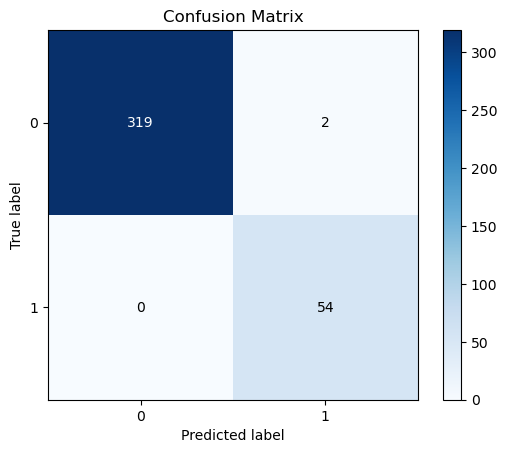

In [39]:
# COLLAPSE
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train, y_train.values.ravel())
y_pred = log_reg_model.predict(x_test)
print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
print(f'Precision : {precision_score(y_test, y_pred)}')
print(f'Recall : {recall_score(y_test, y_pred)}')
print(f'F1 Score : {f1_score(y_test, y_pred)} \n')
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)

<img src="https://th.bing.com/th/id/OIP.wi9ECdApXRemIld2zno7SAHaGg?pid=ImgDet&rs=1" width="500" height="500" />

AUC:  0.9996601820675893 



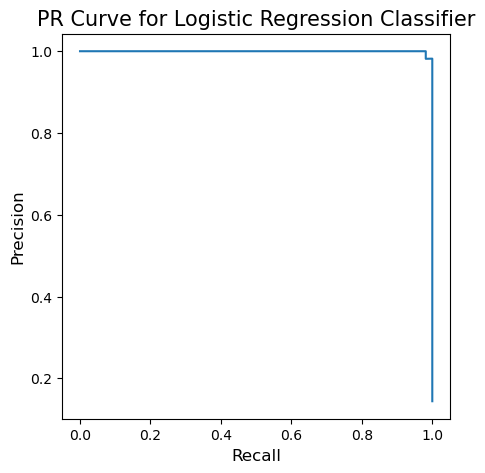

In [40]:
log_reg_y_pred_conf = log_reg_model.predict_proba(x_test)
plot_pr_curve(y_test, log_reg_y_pred_conf, classifier_type='Logistic Regression Classifier')

We don't want to base our evaluation off of accuracy. Since the two classes are very imbalanced (there are far more Negatives/Non-Matches than Positives/Matches) we could technically classify everything as a Negative and get a great accuracy. Better metrics are Recall and Precision:

**Recall** is the percentage of true matches that we correctly identified : TP/(TP + FN)

**Precision** is the percentage of matches we identified that were true matches : TP/(TP + FP)

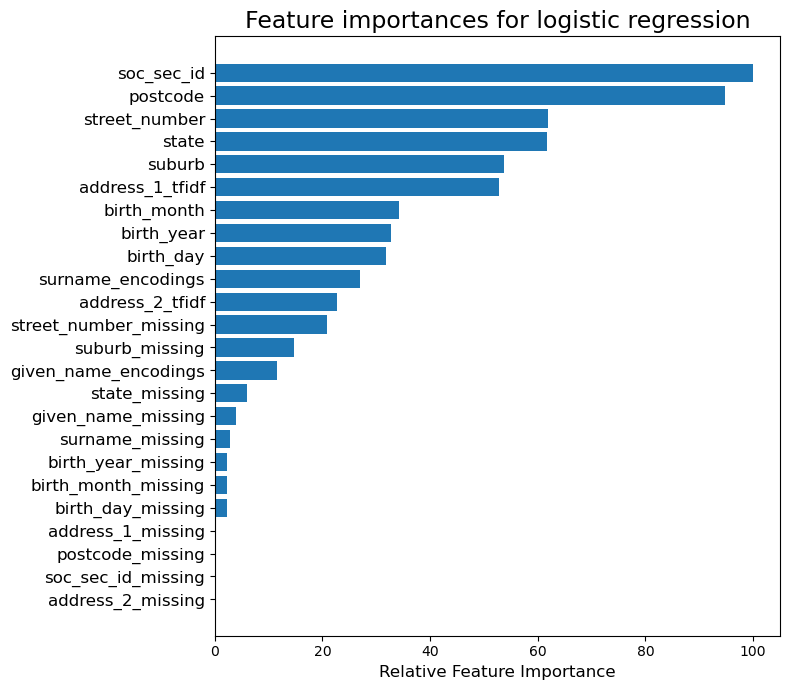

In [41]:
def plot_feature_importances(feature_vectors, model, model_type):
    x_columns = feature_vectors.columns.values.tolist()
    if model_type == 'logistic regression':
        feature_importances = abs(model.coef_[0])
    elif model_type == 'random forest':
        feature_importances = abs(model.feature_importances_)
    feature_importances_relative = 100.0 * (feature_importances / feature_importances.max())
    sorted_idx = np.argsort(feature_importances_relative)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(8,7))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importances_relative[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(x_columns)[sorted_idx], fontsize=12)
    featax.set_xlabel('Relative Feature Importance', fontsize=12)
    featax.set_title(f'Feature importances for {model_type}', fontsize=17)

    plt.tight_layout()   
    plt.show()
    
plot_feature_importances(feature_vectors, model=log_reg_model, model_type='logistic regression')

# Clustering

Any accounts that are identified as pairs will be put into the same cluster, which will cause previously smaller clusters to merge to accommodate

Looking at the resulting clusters is a great way to see how well the model is doing. If there are clusters with a lot of accounts that should not be together, that is a good indicator that the recall is too high. 

In [45]:
def generate_clusters(model, feature_vectors):
    all_data_predictions = model.predict(feature_vectors)
    model_results = feature_vectors.copy()
    model_results['class'] = all_data_predictions
    
    all_matches = model_results.loc[model_results['class']==1]
    
    print(f"Total number of matching pairs : {len(all_matches)}")
    print(f"Percentage of pairs that are a match : {len(all_matches) * 100 /len(model_results)}%")
    
    G = nx.Graph()
    G.add_edges_from(all_matches.index.tolist())
    cluster_list = []
    for connected_component in nx.connected_components(G):
        cluster_list.append(connected_component)
    cluster_list.sort(key=len, reverse=True) # Sorted so that the largest ones are first

    print(f'Number of clusters : {len(cluster_list)}')
    
    return cluster_list

In [46]:
log_reg_cluster_list = generate_clusters(log_reg_model, feature_vectors)
#dec_tree_cluster_list = generate_clusters(dec_tree_model, feature_vectors)

Total number of matching pairs : 1891
Percentage of pairs that are a match : 1.2513317319463468%
Number of clusters : 432


In [47]:
example_df = df.loc[df.index.isin(log_reg_cluster_list[0])]
#example_df = df.loc[df.index.isin(dec_tree_cluster_list[7])]
print(f'Length of cluster : {len(example_df)}')
example_df

Length of cluster : 6


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2490-org,fynn,reid,15,NaN,belongame,surfers paradise,2061,nsw,19390425,6365849
rec-589-dup-1,saah,reid,1,NaN,creston,larnok,5162,nsw,19710725,6614340
rec-589-dup-3,saraoh,ried,NaN,fihelly street,creston,woodhouselee,5162,nsw,19710725,6614340
rec-589-dup-0,sarah,reid,1,fihelly strwet,creston,larnook,5162,nsw,19710725,6614340
rec-589-dup-2,sarah,reid,2,fihelly street,two mile,larnook,5162,nsw,19710725,6614340
rec-589-org,sarah,reid,1,fihelly street,creston,larnook,5162,nsw,19710725,6614340
